In [3]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
import numpy as np
import matplotlib.pyplot as plt
train_count = mnist.train.images.shape[0]
test_count = mnist.test.images.shape[0]
val_count = mnist.validation.images.shape[0]
print ("Images in train: {} validation: {} test: {}".format(train_count,val_count,test_count))

Images in train: 55000 validation: 5000 test: 10000


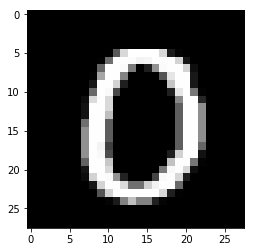

In [5]:
#access first image
first_image = mnist.train.images[10]
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')

In [26]:
batch_size = 100
n_epochs = 50
learning_rate = 0.0001
X= tf.placeholder(tf.float32,[batch_size,784],name="image")
Y= tf.placeholder(tf.float32,[batch_size,10],name="label")
W = tf.Variable(tf.random_normal(shape=[784,10], stddev=0.01),name="weights")
b = tf.Variable(tf.zeros(shape=[1,10]), name="bias")
Z = tf.matmul(X,W) + b
entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Z,labels=Y)
loss = tf.reduce_mean(entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

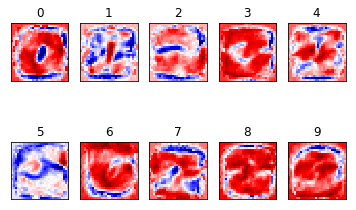

In [30]:
init = tf.global_variables_initializer()
total_correct_preds = 0
with tf.Session() as sess:
    sess.run(init)
    n_batches = int(mnist.train.num_examples/batch_size)
    for i in range(n_epochs):
        for _ in range(n_batches):
            X_batch, Y_batch = mnist.train.next_batch(batch_size)
            sess.run([optimizer,loss], feed_dict={X:X_batch, Y:Y_batch})
    
    n_batches = int(mnist.test.num_examples/batch_size)
    total_correct_pred = 0
    for i in range(n_batches):
        X_batch, Y_batch = mnist.test.next_batch(batch_size)
        _,batch_loss,logits=sess.run([optimizer,loss,Z],feed_dict={X:X_batch,Y:Y_batch})
        preds = tf.nn.softmax(logits)
        correct_preds = tf.equal(tf.argmax(preds,1), tf.argmax(Y_batch,1))
        accuracy = sess.run(tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        weight = sess.run(W)[:,i]
        plt.title(i)
        plt.imshow(weight.reshape([28,28]), cmap=plt.get_cmap('seismic'))
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
    

In [31]:
#test model    
print("Accuracy: {}".format(accuracy))

Accuracy: 0.9399999976158142


In [24]:
plt.show()

In [51]:
def initialize_weight(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

def initialize_bias(shape):
    return tf.Variable(tf.constant(0.1,shape=shape))

def conv_2X2(x,w):
    return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding='SAME')

def max_pool2X2(data):
    return tf.nn.max_pool(data,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")

sess = tf.InteractiveSession()
X= tf.placeholder(tf.float32,[None,784],name="image")
Y= tf.placeholder(tf.float32,[None,10],name="label")

In [52]:
#conv layers
W_conv1 = initialize_weight([5,5,1,32])
b_conv1 = initialize_bias([32])
x_image = tf.reshape(X,[-1,28,28,1])
h_conv1 = tf.nn.relu(conv_2X2(x_image,W_conv1) + b_conv1)
h_pool1 = max_pool2X2(h_conv1)

W_conv2 = initialize_weight([5,5,32,64])
b_conv2 = initialize_bias([64])
h_conv2 = tf.nn.relu(conv_2X2(h_pool1,W_conv2) + b_conv2)
h_pool2 = max_pool2X2(h_conv2)

#densely connected                     
W_dense1 = initialize_weight([7*7*64,1024])
b_dense1 = initialize_weight([1024])
h_pool2_flat = tf.reshape(h_pool2,[-1,7*7*64]) 
h_dense1 = tf.nn.relu(tf.matmul(h_pool2_flat,W_dense1) + b_dense1)

#dropout
keep_prob = tf.placeholder(tf.float32)
h_dense_drop = tf.nn.dropout(h_dense1,keep_prob=keep_prob)
                     
#softmax

W_soft1 = initialize_weight([1024,10])
b_soft1 = initialize_bias([10])
y_conv1 = tf.matmul(h_dense_drop,W_soft1) + b_soft1

entropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits=y_conv1)
train_step = tf.train.AdamOptimizer(1e-4).minimize(entropy)
correct_preds = tf.equal(tf.argmax(y_conv1,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_preds,tf.float32))
sess.run(tf.global_variables_initializer())

for i in range(20000):
    X_batch, Y_batch = mnist.train.next_batch(100)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict = {X:X_batch, Y: Y_batch,keep_prob:1.0})
        print("step:{} train accuracy: {}".format(i, train_accuracy))
    train_step.run(feed_dict={X:X_batch, Y:Y_batch, keep_prob:0.5})

print("Test accuracy: {}".format(accuracy.eval(feed_dict={X:mnist.test.images,Y:mnist.test.labels,keep_prob:1.0})))
                     

step:0 train accuracy: 0.09000000357627869
step:100 train accuracy: 0.25999999046325684
step:200 train accuracy: 0.8199999928474426
step:300 train accuracy: 0.9100000262260437
step:400 train accuracy: 0.8799999952316284
step:500 train accuracy: 0.9200000166893005
step:600 train accuracy: 0.9399999976158142
step:700 train accuracy: 0.9300000071525574
step:800 train accuracy: 0.949999988079071
step:900 train accuracy: 0.9599999785423279
step:1000 train accuracy: 0.9100000262260437
step:1100 train accuracy: 0.9300000071525574
step:1200 train accuracy: 0.949999988079071
step:1300 train accuracy: 0.9599999785423279
step:1400 train accuracy: 0.9800000190734863
step:1500 train accuracy: 0.949999988079071
step:1600 train accuracy: 0.9800000190734863
step:1700 train accuracy: 0.9700000286102295
step:1800 train accuracy: 0.9700000286102295
step:1900 train accuracy: 0.9700000286102295
step:2000 train accuracy: 0.949999988079071
step:2100 train accuracy: 0.9900000095367432
step:2200 train accuracy

In [70]:
preds = y_conv1.eval(feed_dict={X:mnist.test.images,Y:mnist.test.labels,keep_prob:1.0})
predict_labels = []
for p in preds:
    predict_labels.append(np.argmax(p))
actual_matrix = []
for la in mnist.test.labels:
    actual_matrix.append(np.argmax(la))


In [76]:
print("Total test samples:{},predicted_labels:{}".format(len(actual_matrix), len(predict_labels)))
from sklearn.metrics import classification_report
print(classification_report(actual_matrix,predict_labels))

Total test samples:10000,predicted_labels:10000
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       980
          1       0.99      1.00      1.00      1135
          2       0.99      0.99      0.99      1032
          3       0.99      0.99      0.99      1010
          4       0.99      0.99      0.99       982
          5       0.99      0.99      0.99       892
          6       0.99      0.99      0.99       958
          7       0.99      0.99      0.99      1028
          8       0.99      0.99      0.99       974
          9       0.99      0.99      0.99      1009

avg / total       0.99      0.99      0.99     10000

